In [1]:
## Import Python libraries ## 

import numpy as np
import xsimlab as xs
import matplotlib.pyplot as plt
import xarray as xr


%matplotlib inline
%reload_ext xsimlab.ipython


import fastscape

from orographic_precipitation.fastscape_ext import precip_model
from fastscape.processes import Bedrock

In [2]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.5.0
fastscape version:  0.1.0


In [3]:
## Build xarray-simlab model ##
SouthernAndesLEM = precip_model
SouthernAndesLEM = precip_model.drop_processes(['init_topography'])
SouthernAndesLEM = SouthernAndesLEM.update_processes({'bedrock': Bedrock})

SouthernAndesLEM

<xsimlab.Model (17 processes, 26 inputs)>
grid
    shape                  [in] ('shape_yx',) nb. of grid nodes in ...
    length                 [in] ('shape_yx',) total grid length in ...
boundary
    status                 [in] () or ('border',) node status at bo...
fs_context
uplift
    rate                   [in] () or ('y', 'x') uplift rate
tectonics
surf2erode
flow
orographic
    lapse_rate             [in] environmental lapse rate
    lapse_rate_m           [in] moist adiabatic lapse rate
    ref_density            [in] reference saturation water vapor de...
    latitude               [in] latitude
    precip_base            [in] () or ('y', 'x') background, non-or...
    rainfall_frequency  [inout] daily rainfall frequency
    wind_speed             [in] wind speed
    wind_dir               [in] wind direction (azimuth)
    conv_time              [in] conversion time
    fall_time              [in] fallout time
    nm                     [in] moist stability frequency
    hw  

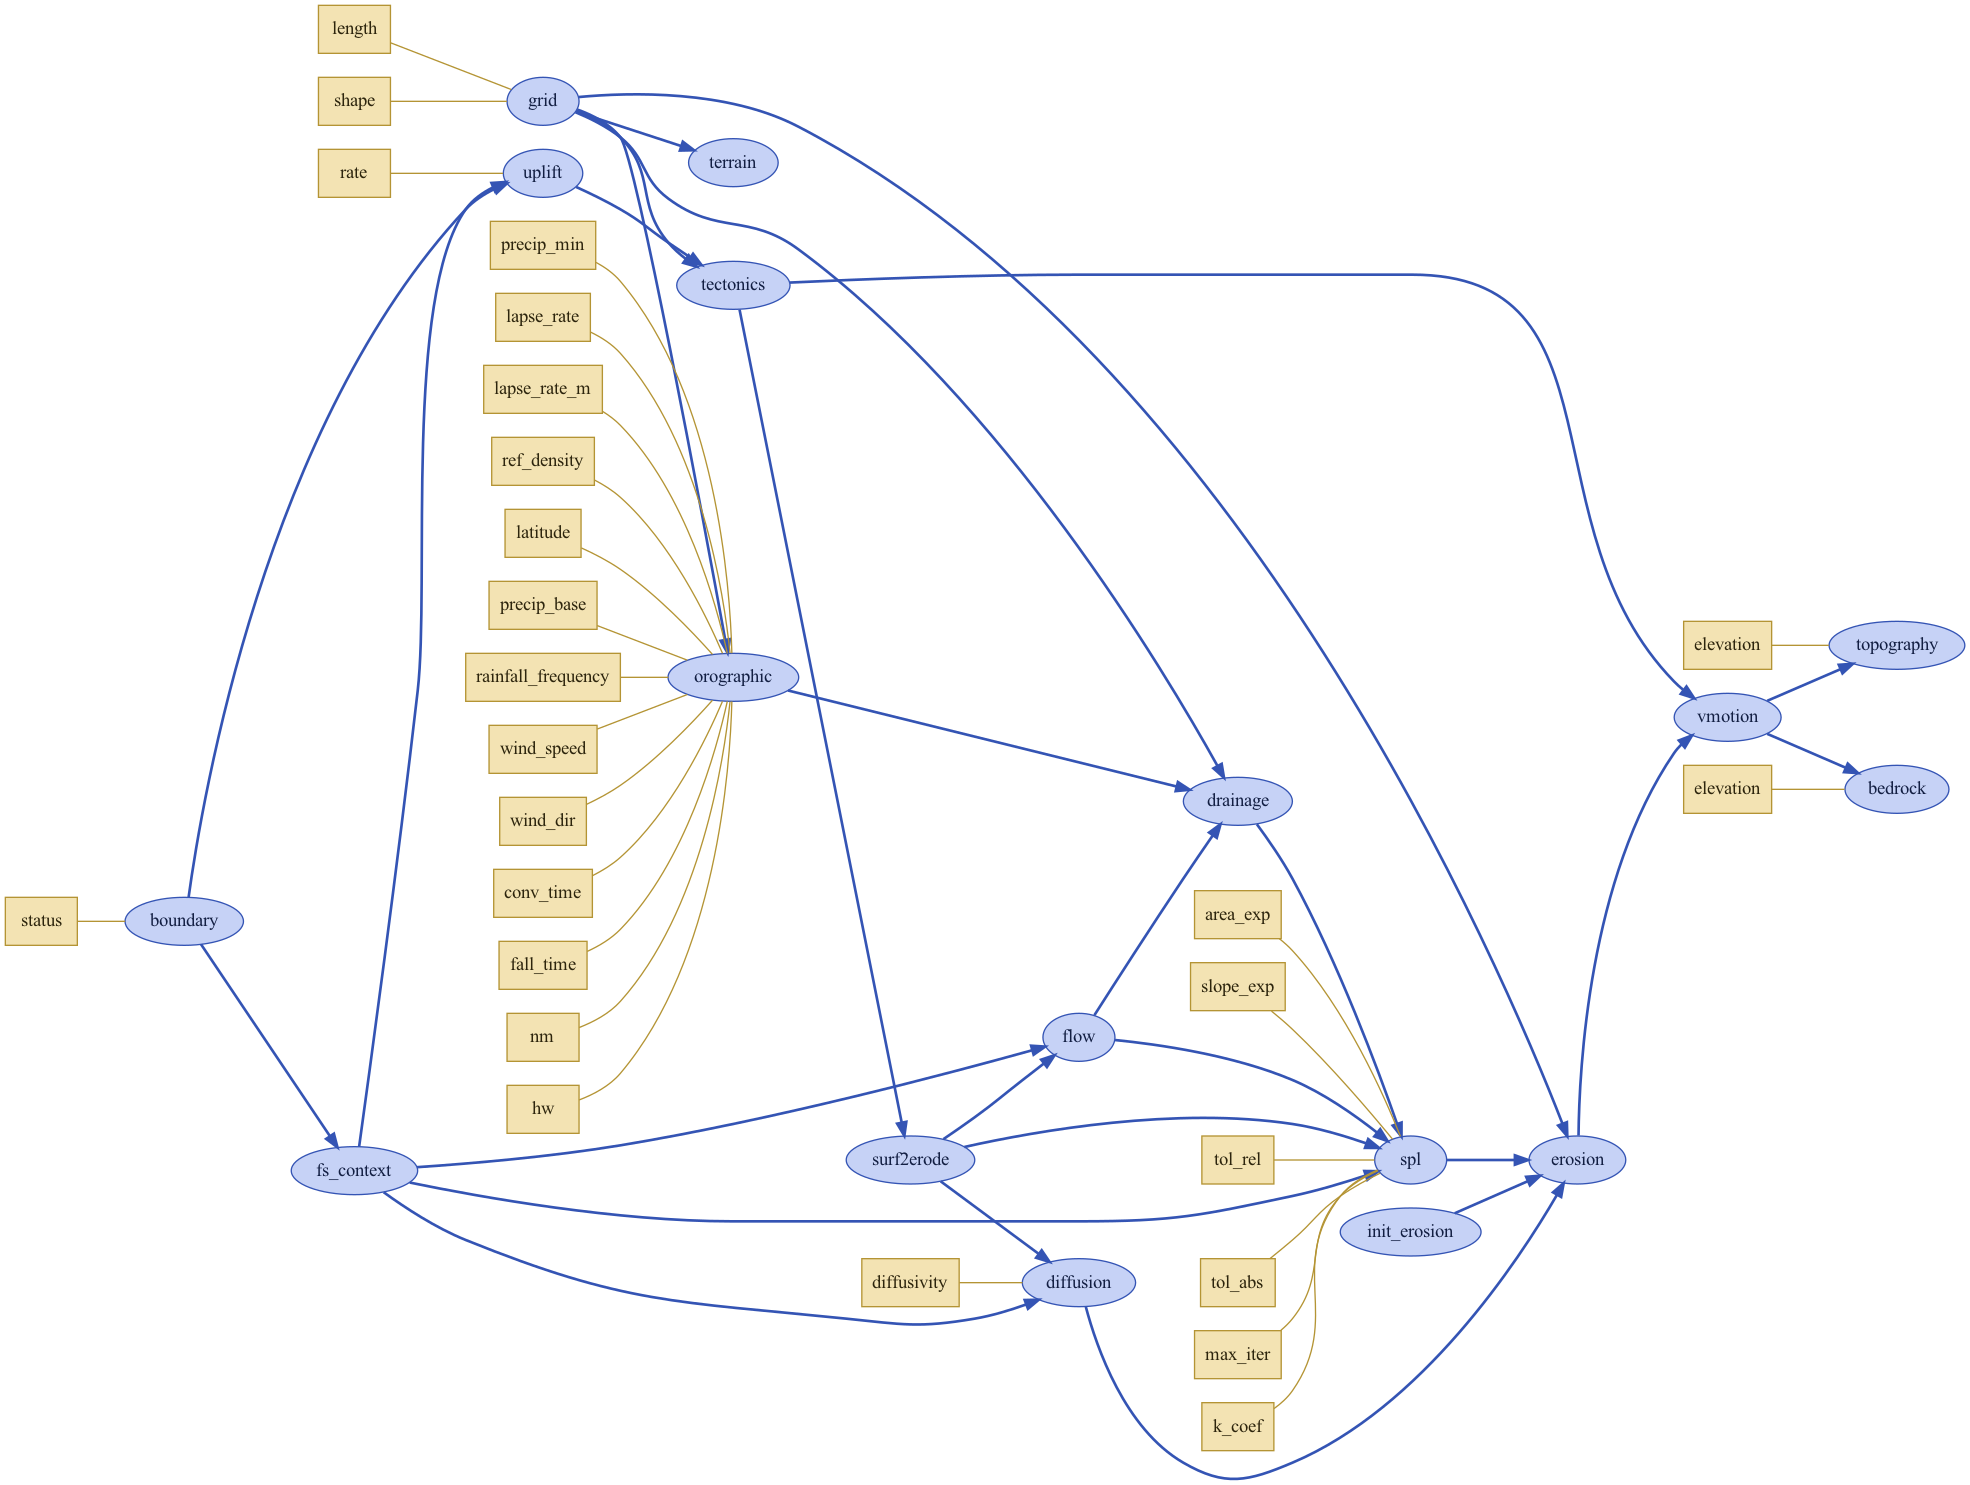

In [4]:
## Visualise xarray-simlab ##
SouthernAndesLEM.visualize(show_inputs='True')

In [5]:
## Model dimensions/grid dimensions ##
nx = 100
ny = 100
nn = nx * ny

xl = 100.e3
yl = 100.e3

BoundaryCondition = ['looped', 'looped', 'fixed_value', 'fixed_value']

## Model time and time stepping ##
EndTime_1 = 5e6
EndTime_2 = 5e6
EndTime_3 = 8e6
TimeSteps_1 = 10001
TimeSteps_2 = 10001
TimeSteps_3 = 16001

# EndTime = 1e6
# TimeSteps = 1001
ModelTime_1 = np.linspace(0., EndTime_1, TimeSteps_1)
ModelTime_2 = np.linspace(0., EndTime_2, TimeSteps_2)
ModelTime_3 = np.linspace(0., EndTime_3, TimeSteps_3)

PlotStep = 100

## Tectonics ##
k_coef= 2.5e-5
area_exp = 0.4
slope_exp = 1.0
diffusion_diffusivity = 0.


## Orographic ##
lapse_rate = -5.4 #mean lapse rate of area not too far away 
lapse_rate_m = -6.5 #left default
ref_density = 7.4e-3  #left default
rainfall_frequency = 5 #could not find high resolution data for hourly rainfall in the area of patagonia i was interested in looking at so just an estimate
latitude = -50  #latitude around the area north in the Patagonian Andes
precip_base =  2 #not sure if I should change this or not
wind_speed = 10 #base to start with 
wind_dir = 270  # estimated direction given weather info 
precip_min = 0.1 #default
conv_time = 2000 #2000 thesis value
fall_time = 2000 #2000 thesis value
nm = 0.003  #0.03 #thesis value
hw = 5000  #default


## Initial topography ##
WhiteNoiseLevel = 50 # in [m], amplitude of noise

## Seed for Reproducibility ##
RandomSeed = 42

In [6]:
import os
import numpy as np
import xarray as xr
import xsimlab as xs

# Load downscaled elevation and uplift rate from NetCDF
dem_output = '/Users/lucasguthrieallan/Desktop/GISSTUFF/downscaled_demnew.nc'
uplift_output = '/Users/lucasguthrieallan/Desktop/GISSTUFF/downscaled_upliftnew.nc'

dem_ds = xr.open_dataset(dem_output)
uplift_ds = xr.open_dataset(uplift_output)

# Extract variables
initial_topography = dem_ds["elevation"].values  # Shape should match [nx, ny]
uplift_rate = uplift_ds["uplift_rate"].values  # Shape should match [nx, ny]

# Ensure shapes match the model grid (adjust if necessary)
nx, ny = initial_topography.shape  # Get dimensions from DEM
# Directory to save Zarr files
output_dir = "simulation_outputs"
os.makedirs(output_dir, exist_ok=True)

# Define lapse_rate_m values to test
lapse_rate_m_values = [-6., -5.5, -5.2, -4.4, -3.6, -2.8, -2.]  # 

# Time steps to visualize
time_indices = [0, 1, 10, 100, 1000, 10000]
mean_elevations = []

# Loop through lapse_rate_m values and run simulations
for lapse_rate_m in lapse_rate_m_values:
    print(f"Running simulation for lapse_rate_m = {lapse_rate_m}")
    
    # Set up the model with the current lapse_rate_m
    in_ds_lapse = xs.create_setup(
        model=SouthernAndesLEM,
        clocks={
            'time': ModelTime_1,
            'output': ModelTime_1[::PlotStep]
        },
        master_clock='time',
        input_vars={
            'grid': {'shape': [nx, ny], 'length': [xl, yl]},
            'boundary': {'status': BoundaryCondition},
            'topography': {'elevation': initial_topography},
            'bedrock': {'elevation': initial_topography},
            'uplift': {'rate': uplift_rate},
            'spl': {'k_coef': k_coef, 'area_exp': area_exp, 'slope_exp': slope_exp},
            'diffusion': {'diffusivity': diffusion_diffusivity},
            'orographic': {
                'lapse_rate': lapse_rate,
                'lapse_rate_m': lapse_rate_m,  # Adjusted lapse_rate_m
                'ref_density': ref_density,
                'rainfall_frequency': rainfall_frequency,  # Keep rainfall_frequency
                'latitude': latitude,
                'precip_base': precip_base,
                'wind_speed': wind_speed,
                'wind_dir': wind_dir,
                'precip_min': precip_min,
                'conv_time': conv_time,
                'fall_time': fall_time,
                'nm': nm,
                'hw': hw,
            },
        },
        output_vars={'topography__elevation': 'time', 'orographic__precip_rate': 'time'}
    )

    # Run the simulation
    with xs.monitoring.ProgressBar():
        out_ds_lapse = in_ds_lapse.xsimlab.run(model=SouthernAndesLEM)
    
    # Store simulation results in Zarr format
    zarr_filename = os.path.join(output_dir, f"simulation_lapse_rate_m_{lapse_rate_m:.2f}.zarr")
    out_ds_lapse.to_zarr(zarr_filename, mode='w')
    print(f"Saved results for lapse_rate_m = {lapse_rate_m} to {zarr_filename}")

Running simulation for lapse_rate_m = -6.0


             0% | initialize 

Saved results for lapse_rate_m = -6.0 to simulation_outputs/simulation_lapse_rate_m_-6.00.zarr
Running simulation for lapse_rate_m = -5.5


             0% | initialize 

Saved results for lapse_rate_m = -5.5 to simulation_outputs/simulation_lapse_rate_m_-5.50.zarr
Running simulation for lapse_rate_m = -5.2


             0% | initialize 

Saved results for lapse_rate_m = -5.2 to simulation_outputs/simulation_lapse_rate_m_-5.20.zarr
Running simulation for lapse_rate_m = -4.4


             0% | initialize 

Saved results for lapse_rate_m = -4.4 to simulation_outputs/simulation_lapse_rate_m_-4.40.zarr
Running simulation for lapse_rate_m = -3.6


             0% | initialize 

Saved results for lapse_rate_m = -3.6 to simulation_outputs/simulation_lapse_rate_m_-3.60.zarr
Running simulation for lapse_rate_m = -2.8


             0% | initialize 

Saved results for lapse_rate_m = -2.8 to simulation_outputs/simulation_lapse_rate_m_-2.80.zarr
Running simulation for lapse_rate_m = -2.0


             0% | initialize 

Saved results for lapse_rate_m = -2.0 to simulation_outputs/simulation_lapse_rate_m_-2.00.zarr


Available lapse_rate_m values in dataset: [-9.2 -8.4 -7.6 -6.8 -6.  -5.5 -5.2 -4.4 -3.6 -2.8 -2. ]


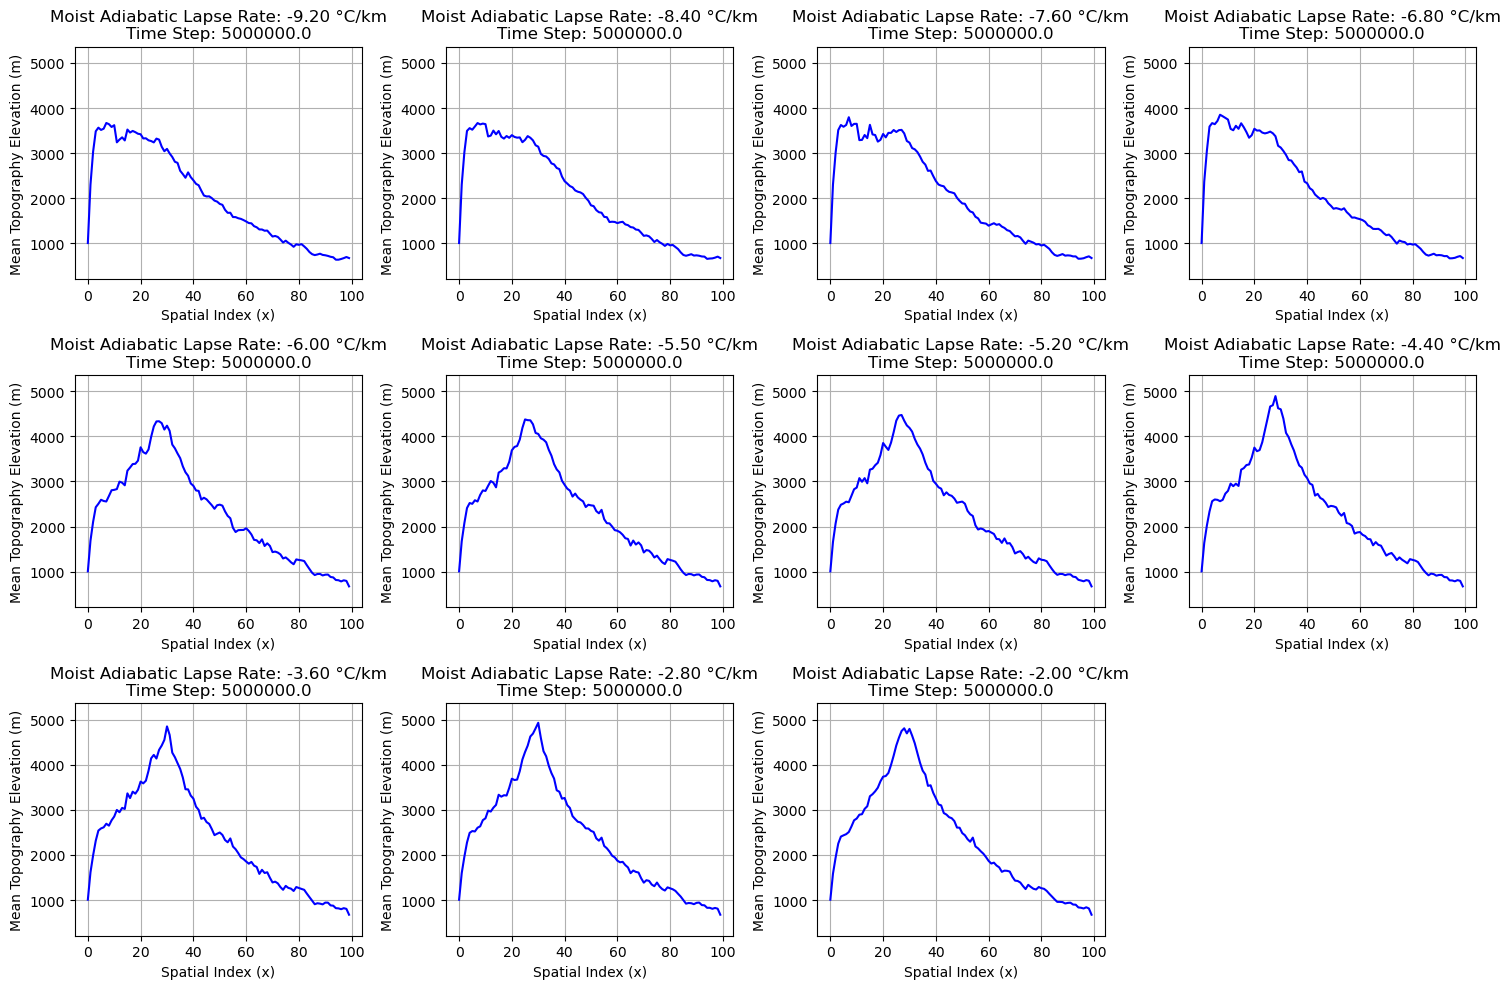

In [11]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by lapse_rate_m values
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_lapse_rate_m_") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))  # Extract and sort lapse_rate_m values

# Define the lapse_rate_m values to plot
desired_lapse_rates = [-9.2, -8.4, -7.6, -6.8, -6., -5.5, -5.2, -4.4, -3.6, -2.8, -2.] # Ensure it matches simulation values

# Load datasets and attach lapse_rate_m as a coordinate
datasets = []
lapse_rates = []

for zarr_file in zarr_files:
    lapse_rate_m = float(zarr_file.split("_")[-1][:-5])  # Extract lapse_rate_m from filename
    ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
    
    # Add lapse_rate_m as a coordinate
    ds = ds.assign_coords(lapse_rate_m=lapse_rate_m)
    
    datasets.append(ds)
    lapse_rates.append(lapse_rate_m)

# Concatenate datasets along the new lapse_rate_m dimension
combined_ds = xr.concat(datasets, dim="lapse_rate_m")

# Ensure lapse_rate_m is a dimension and coordinate
combined_ds = combined_ds.sortby("lapse_rate_m")

# Print available values for debugging
print("Available lapse_rate_m values in dataset:", combined_ds.lapse_rate_m.values)

# Fix: Use nearest selection for valid lapse_rate_m values
valid_lapse_rates = []
for lr in desired_lapse_rates:
    try:
        elevation_data = combined_ds.topography__elevation.isel(time=-1).sel(lapse_rate_m=lr, method="nearest").mean(dim='x')
        valid_lapse_rates.append(lr)
    except KeyError:
        print(f"Skipping {lr}: No matching data found.")

# Adjust number of rows and columns based on valid lapse_rate_m values
n_valid = len(valid_lapse_rates)
ncols = 4  # Define number of columns
nrows = (n_valid // ncols) + (1 if n_valid % ncols != 0 else 0)  # Calculate rows needed

# Create subplots dynamically based on valid lapse_rate_m values
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
axes = axes.flatten()

# Initialize variables to track global min and max for consistent y-axis scaling
global_min_elevation = np.inf
global_max_elevation = -np.inf

# First, loop to find the global min and max of the mean topography elevations
for lr in valid_lapse_rates:
    elevation_data = combined_ds.topography__elevation.isel(time=-1).sel(lapse_rate_m=lr, method="nearest").mean(dim='x')
    global_min_elevation = min(global_min_elevation, elevation_data.min())
    global_max_elevation = max(global_max_elevation, elevation_data.max())

# Extend y-axis range with some padding
padding = (global_max_elevation - global_min_elevation) * 0.1  # 10% padding
global_min_elevation -= padding
global_max_elevation += padding

# Plot only for valid lapse_rate_m values
for idx, lr in enumerate(valid_lapse_rates):
    ax = axes[idx]
    time_step = str(combined_ds.time[-1].values)  # Extract the last time step value
    title = f"Moist Adiabatic Lapse Rate: {lr:.2f} °C/km\nTime Step: {time_step}"
    
    # Get the mean elevation for this lapse_rate_m at the last time step
    elevation_data = combined_ds.topography__elevation.isel(time=-1).sel(lapse_rate_m=lr, method="nearest").mean(dim='x')
    
    # Plot the elevation data as a line plot
    ax.plot(elevation_data, label='Mean Topography Elevation', color='blue')
    
    ax.set_title(title)
    ax.set_ylabel("Mean Topography Elevation (m)")
    ax.set_xlabel("Spatial Index (x)")
    ax.set_ylim(global_min_elevation, global_max_elevation)
    ax.grid(True)

# Hide unused axes
for ax in axes[len(valid_lapse_rates):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()


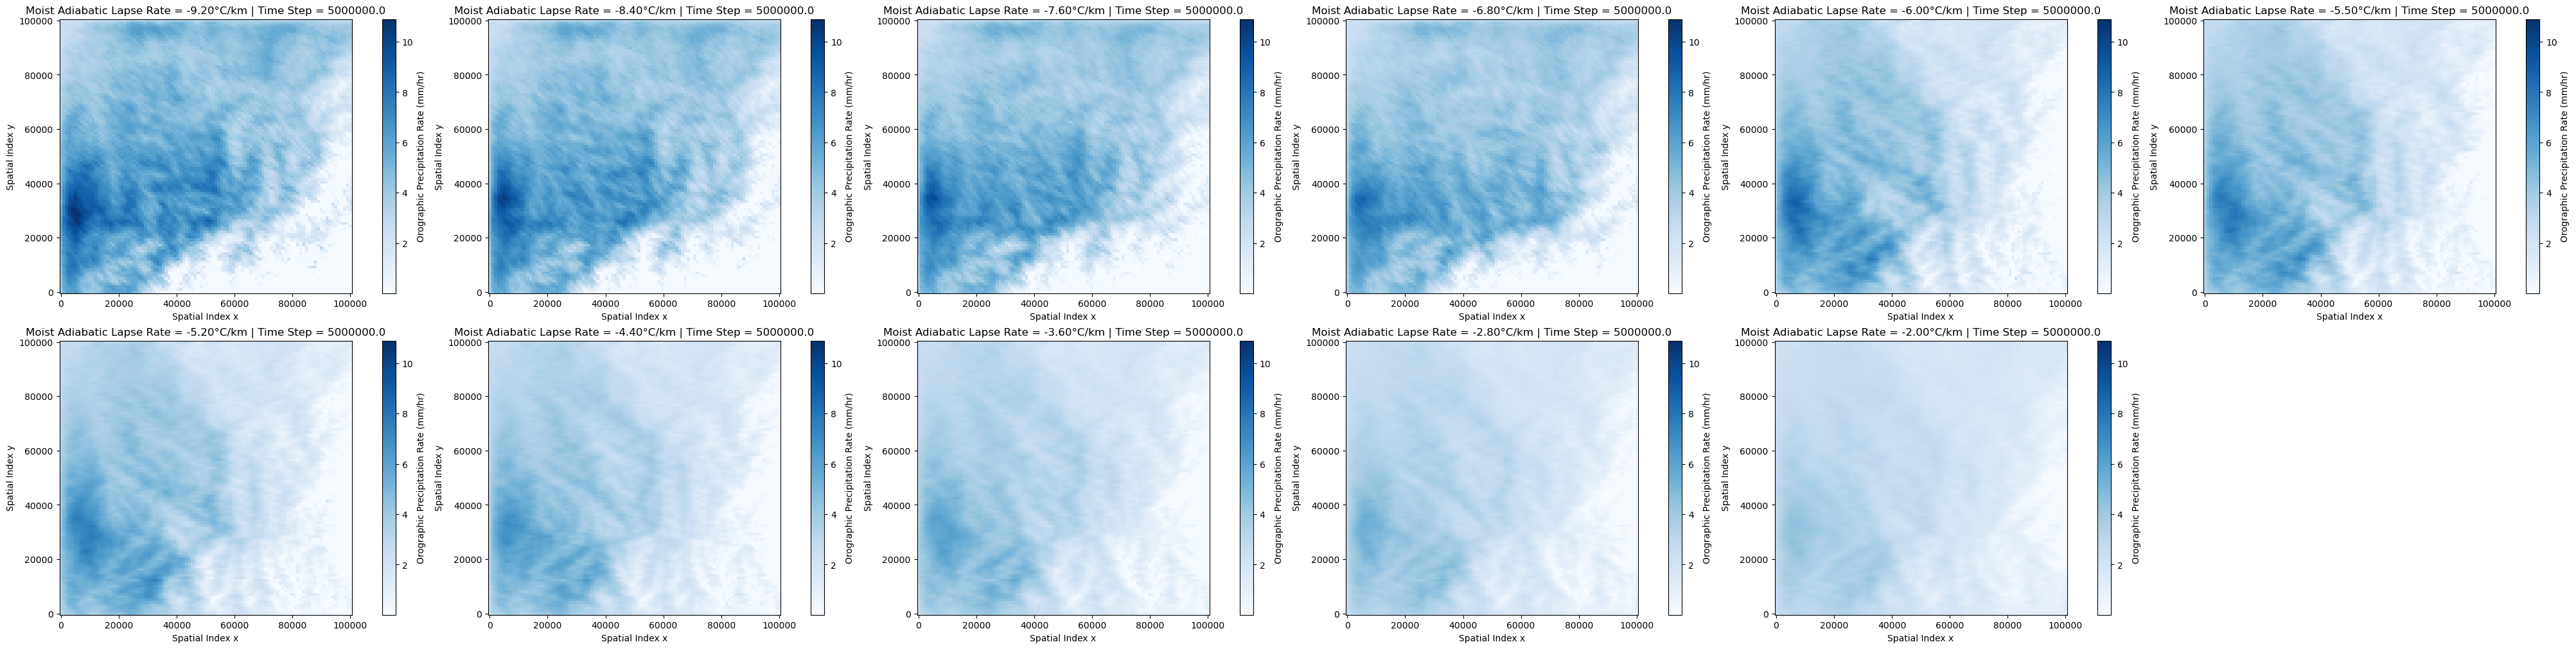

In [31]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by lapse_rate_m values
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_lapse_rate_m") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))  # Extract lapse_rate_m values

# Define specific lapse_rate_m values to plot
desired_lapse_rates =  [-9.2, -8.4, -7.6, -6.8, -6., -5.5,-5.2, -4.4, -3.6, -2.8, -2.]
  # Adjust based on your simulations

# Load datasets and attach lapse_rate_m as a coordinate
datasets = []
lapse_rates = []
time_steps = []

# Initialize global min/max precipitation trackers
precip_min = np.inf
precip_max = -np.inf

for zarr_file in zarr_files:
    lapse_rate_m = float(zarr_file.split("_")[-1][:-5])  # Extract value
    if lapse_rate_m in desired_lapse_rates:  # Only include selected values
        ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
        
        # Add lapse_rate_m as a coordinate
        ds = ds.assign_coords(lapse_rate_m=lapse_rate_m)
        
        datasets.append(ds)
        lapse_rates.append(lapse_rate_m)  # Append only desired values
        
        # Extract the last time step
        time_steps.append(ds.time.values[-1])

        # Update global min/max precipitation for consistent scale
        precip = ds.orographic__precip_rate.isel(time=-1)
        precip_min = min(precip_min, precip.min().values)
        precip_max = max(precip_max, precip.max().values)

# Concatenate datasets along the new lapse_rate_m dimension
combined_ds = xr.concat(datasets, dim="lapse_rate_m")
combined_ds = combined_ds.sortby("lapse_rate_m")  # Ensure correct order

# Calculate grid layout for subplots
num_plots = len(lapse_rates)
num_cols = (num_plots + 1) // 2  
num_rows = (num_plots + num_cols - 1) // num_cols  

# 📌 Plot: Precipitation Maps for Selected Lapse Rate Values at Final Time Step
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(40, 10), constrained_layout=True)
axes = axes.flatten()

# Loop over datasets and create plots
for ax, ds, lapse_rate_m, time_step in zip(axes, datasets, lapse_rates, time_steps):
    # Plot precipitation at the final time step
    precip_data = ds.orographic__precip_rate.isel(time=-1)
    precip_data.plot(ax=ax, vmin=precip_min, vmax=precip_max, cmap='Blues', cbar_kwargs={"label":"Orographic Precipitation Rate (mm/hr)"})
    ax.set_title(f"Moist Adiabatic Lapse Rate = {lapse_rate_m:.2f}°C/km | Time Step = {time_step}", fontsize=12)
    ax.set_xlabel("Spatial Index x")
    ax.set_ylabel("Spatial Index y")

# Hide any unused subplots
for i in range(len(lapse_rates), len(axes)):
    fig.delaxes(axes[i])

plt.savefig("Precipitation_LapseRate_Selected.png")
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()


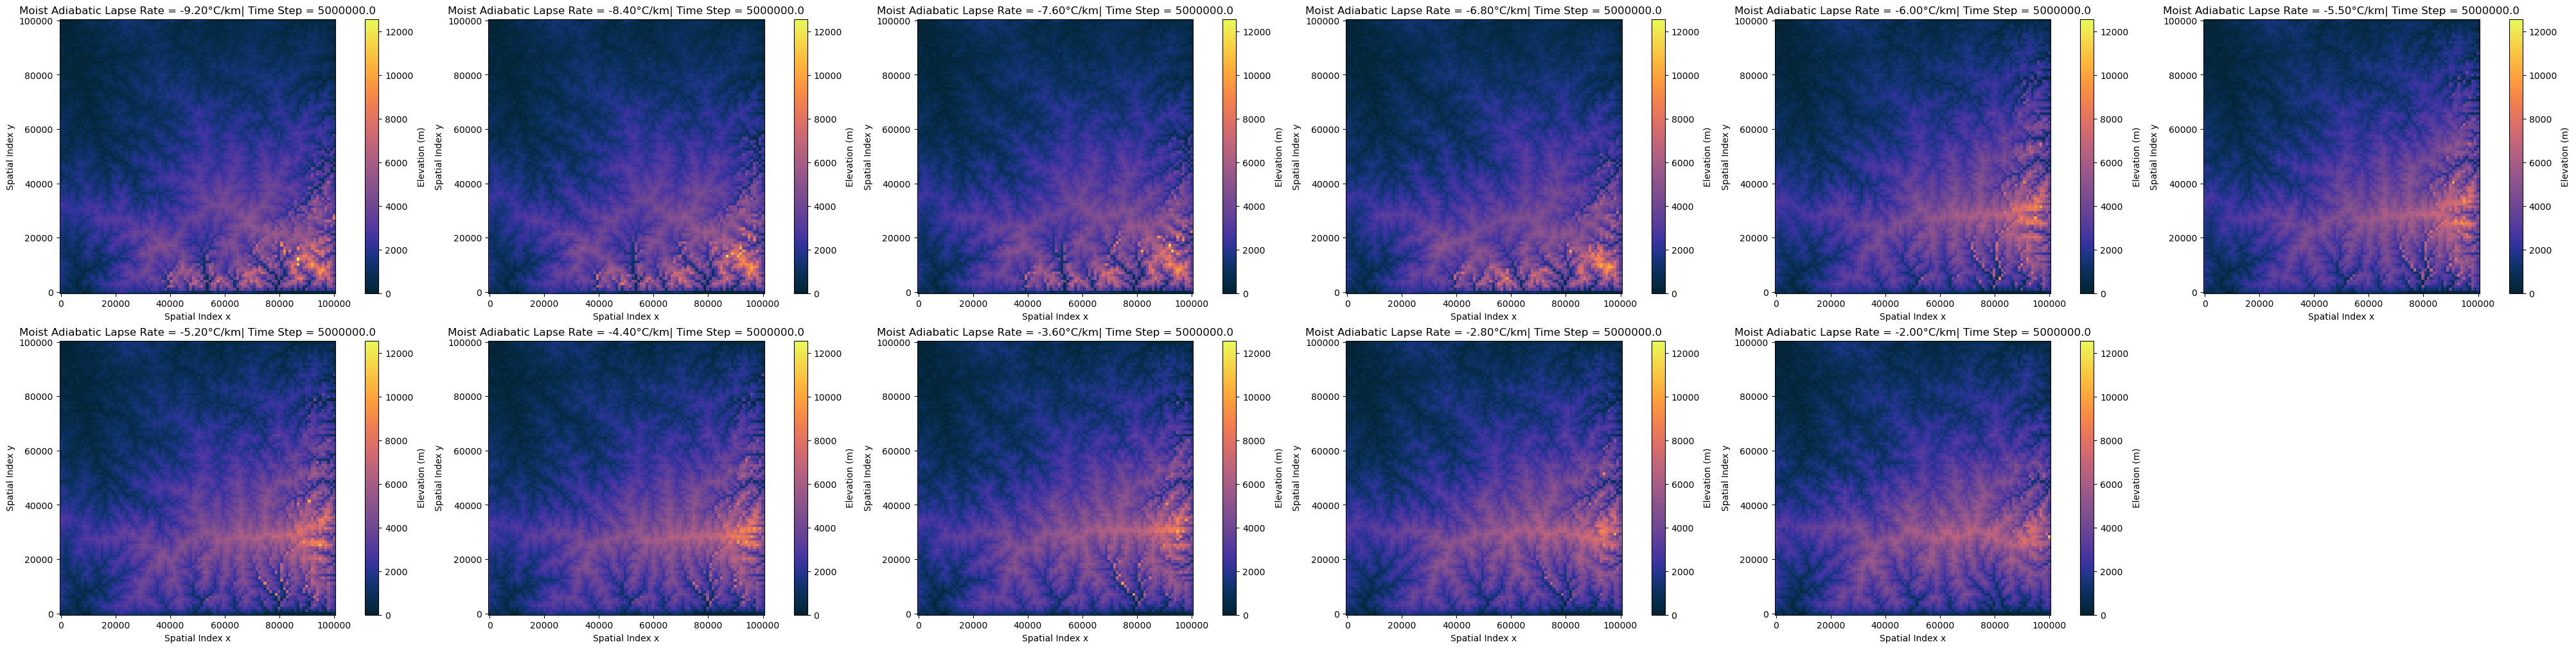

In [30]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean  # Improved colormap
import dask

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by lapse_rate_m
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_lapse_rate_m") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))  # Extract lapse_rate_m from filename

# Define specific lapse_rate_m values to plot
desired_lapse_rates = [-9.2, -8.4, -7.6, -6.8, -6., -5.5,-5.2, -4.4, -3.6, -2.8, -2.] # Adjust based on your simulations

# Load datasets and attach lapse_rate_m as a coordinate
datasets = []
lapse_rates = []
time_steps = []

elevation_min = np.inf  # Track global min
elevation_max = -np.inf  # Track global max

for zarr_file in zarr_files:
    lapse_rate_m = float(zarr_file.split("_")[-1][:-5])  # Extract value
    if lapse_rate_m in desired_lapse_rates:  # Only include selected values
        ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
        
        # Add lapse_rate_m as a coordinate
        ds = ds.assign_coords(lapse_rate_m=lapse_rate_m)
        
        datasets.append(ds)
        lapse_rates.append(lapse_rate_m)  # Append only desired values
        
        # Extract the last time step
        time_steps.append(ds.time.values[-1])

         # Update global min/max for consistent scaling
        elevation_min = min(elevation_min, ds.topography__elevation.isel(time=-1).min().values)
        elevation_max = max(elevation_max, ds.topography__elevation.isel(time=-1).max().values)

# Concatenate datasets along the new lapse_rate_m dimension
combined_ds = xr.concat(datasets, dim="lapse_rate_m")
combined_ds = combined_ds.sortby("lapse_rate_m")  # Ensure correct order

# Calculate grid layout for subplots
num_plots = len(lapse_rates)
num_cols = (num_plots + 1) // 2  
num_rows = (num_plots + num_cols - 1) // num_cols  

# 📌 Plot: Elevation Maps for Selected Lapse Rates at Final Time Step
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(40, 10), constrained_layout=True)
axes = axes.flatten()

# Loop over datasets and create plots
for ax, ds, lapse_rate_m, time_step in zip(axes, datasets, lapse_rates, time_steps):
    ds.topography__elevation.isel(time=-1).plot(ax=ax, vmin=elevation_min, vmax=elevation_max, cmap=cmocean.cm.thermal, cbar_kwargs={"label": "Elevation (m)"})
    ax.set_title(f"Moist Adiabatic Lapse Rate = {lapse_rate_m:.2f}°C/km| Time Step = {time_step}", fontsize=12)
    ax.set_xlabel("Spatial Index x")
    ax.set_ylabel("Spatial Index y")

# Hide any unused subplots
for i in range(len(lapse_rates), len(axes)):
    fig.delaxes(axes[i])

plt.savefig("Elevation_LapseRateM_Selected.png")
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()

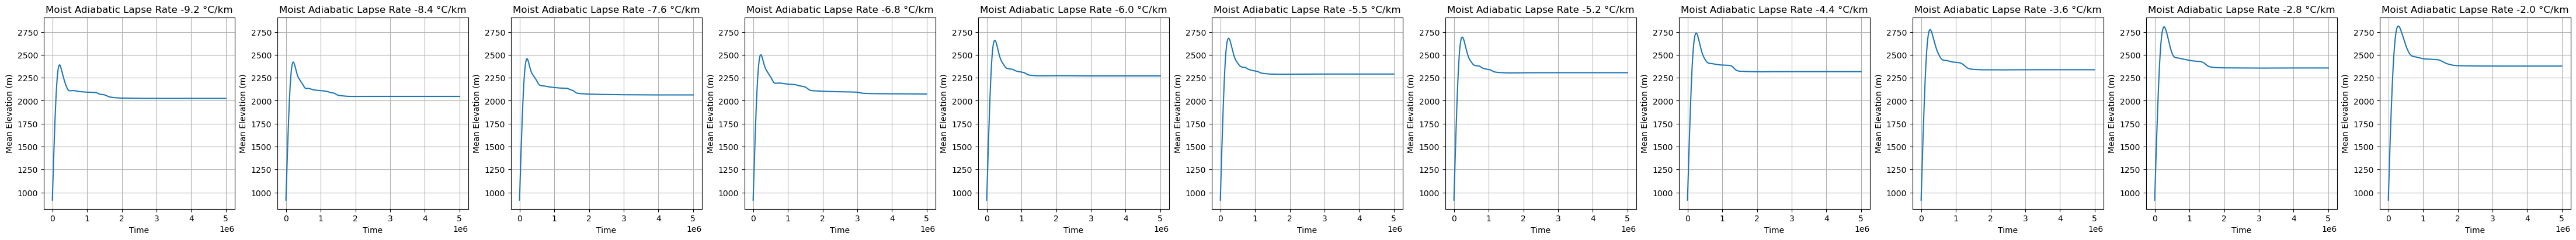

In [27]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and filter for lapse_rate_m
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_lapse_rate_m") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))

# Load datasets and compute mean elevations
datasets = []
lapse_rates = []
mean_elevations = []

for zarr_file in zarr_files:
    lapse_rate = float(zarr_file.split("_")[-1][:-5])  # Extract lapse rate from filename
    ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
    datasets.append(ds)
    lapse_rates.append(lapse_rate)  # Updated: Correctly appending lapse_rate value
    mean_elevations.append(ds.topography__elevation.mean(dim=("x", "y")))  # Compute mean elevation

# If no valid datasets are found, raise an error
if not datasets:
    raise ValueError("No valid datasets found. Check the Zarr files in the directory.")

# Determine common y-axis limits with padding
y_min = min(elev.min().values for elev in mean_elevations)
y_max = max(elev.max().values for elev in mean_elevations)
padding = 0.05 * (y_max - y_min)  # Add 5% padding

y_min -= padding
y_max += padding

# Create mean elevation plots
num_lapse_rates = len(lapse_rates)
fig, axes = plt.subplots(nrows=1, ncols=num_lapse_rates, figsize=(max(num_lapse_rates * 4, 8), 4), constrained_layout=True)

# Ensure `axes` is always iterable (even for 1 subplot)
if num_lapse_rates == 1:
    axes = [axes]

for ax, ds, lapse_rate, mean_elev in zip(axes, datasets, lapse_rates, mean_elevations):
    ax.plot(ds.time, mean_elev, label=f"Adiabatic Lapse Rate {lapse_rate} °C/km")
    ax.set_title(f"Moist Adiabatic Lapse Rate {lapse_rate} °C/km")
    ax.set_xlabel("Time")
    ax.set_ylabel("Mean Elevation (m)")
    ax.set_ylim(y_min, y_max)  # Set consistent y-axis limits
    ax.grid()

# Save and show the figure
plt.savefig("Mean_Elevation_LapseRate_Comparison.png")
plt.show()

# Close datasets
for ds in datasets:
    ds.close()


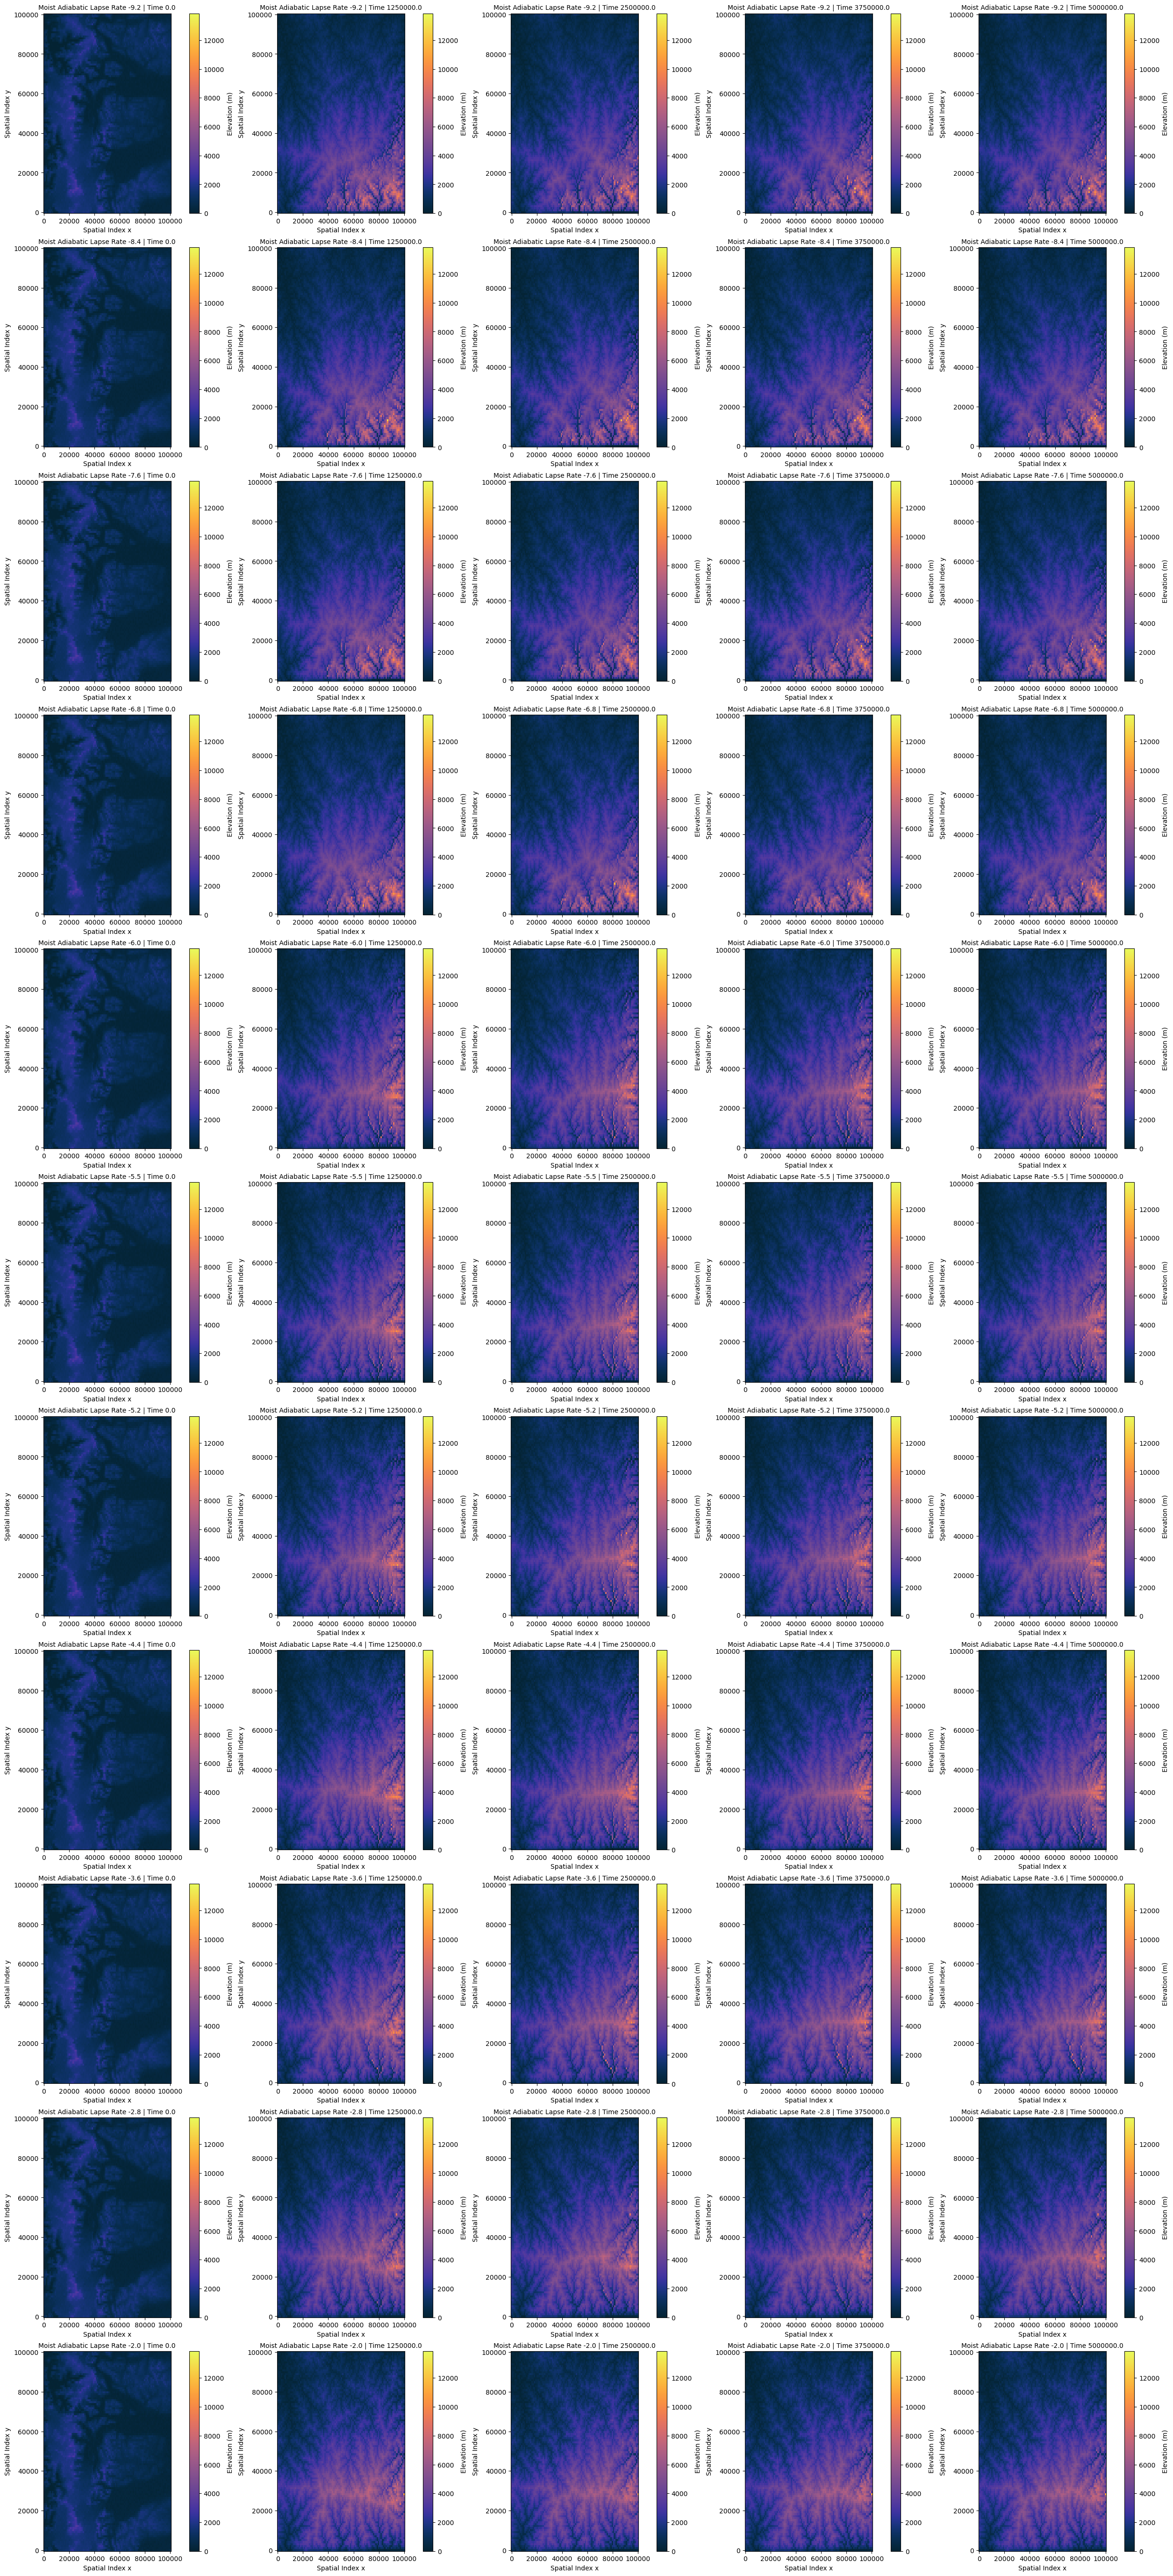

In [21]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean  # Improved colormap
import dask

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by lapse_rate_m
zarr_files = [f for f in os.listdir(output_dir) if f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))

# Define the specific lapse_rate_m values to plot
desired_lapse_rates = [-9.2, -8.4, -7.6, -6.8, -6., -5.5,-5.2, -4.4, -3.6, -2.8, -2.]

# Load datasets
datasets = []
lapse_rates = []
time_steps = []

elevation_min = np.inf  # Track global min
elevation_max = -np.inf  # Track global max

for zarr_file in zarr_files:
    lapse_rate_m = float(zarr_file.split("_")[-1][:-5])  # Extract lapse_rate_m from filename
    if lapse_rate_m in desired_lapse_rates:
        ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
        ds = ds.assign_coords(lapse_rate_m=lapse_rate_m)
        datasets.append(ds)
        lapse_rates.append(lapse_rate_m)

        # Update global min/max elevation values
        elevation_min = min(elevation_min, ds.topography__elevation.min().values)
        elevation_max = max(elevation_max, ds.topography__elevation.max().values)

# Concatenate datasets along the new lapse_rate_m dimension
combined_ds = xr.concat(datasets, dim="lapse_rate_m")
combined_ds = combined_ds.sortby("lapse_rate_m")

# Select time steps: First, last, and a few in between
time_indices = np.linspace(0, combined_ds.dims["time"] - 1, num=5, dtype=int)  # Adjust num=5 for more/less intervals

# Create plots
num_lapse_rates = len(lapse_rates)
num_time_steps = len(time_indices)
fig, axes = plt.subplots(nrows=num_lapse_rates, ncols=num_time_steps, figsize=(num_time_steps * 5, num_lapse_rates * 5), constrained_layout=True)

# Loop over lapse_rate_m values and time steps
for i, (ds, lapse_rate_m) in enumerate(zip(datasets, lapse_rates)):
    for j, t_idx in enumerate(time_indices):
        ax = axes[i, j]
        ds.topography__elevation.isel(time=t_idx).plot(ax=ax, vmin=elevation_min, vmax=elevation_max, cmap=cmocean.cm.thermal, cbar_kwargs={"label": "Elevation (m)"} )
        ax.set_title(f"Moist Adiabatic Lapse Rate {lapse_rate_m:.1f} | Time {ds.time.values[t_idx]:.1f}", fontsize=10)
        ax.set_xlabel("Spatial Index x")
        ax.set_ylabel("Spatial Index y")

# Save and show the figure
plt.savefig("Elevation_LapseRate_TimeEvolution.png")
plt.show()

# Close datasets
for ds in datasets:
    ds.close()


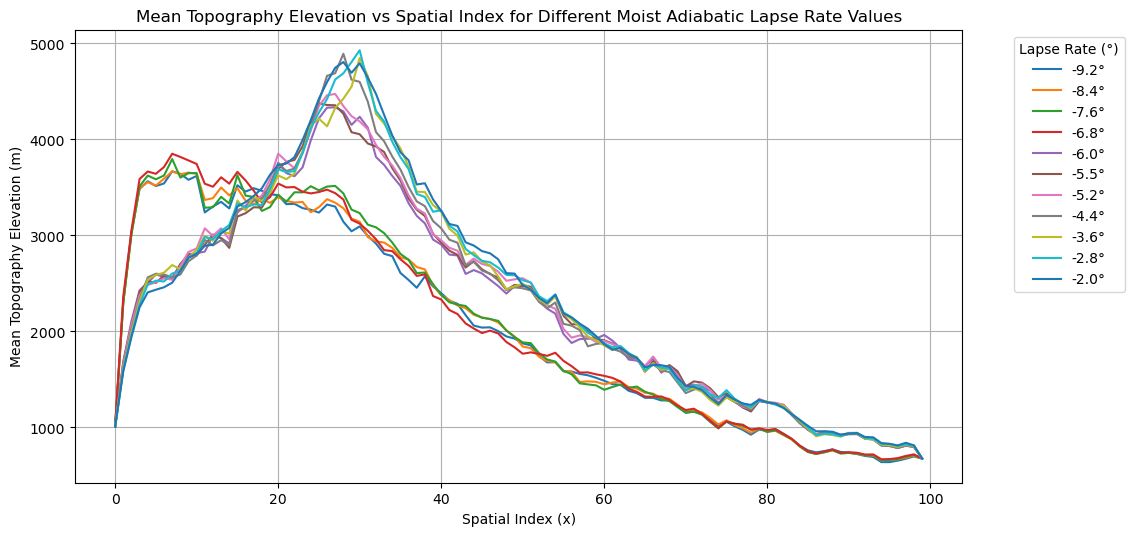

In [20]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by lapse_rate_m
zarr_files = [f for f in os.listdir(output_dir) if f.endswith(".zarr")]

# Extract lapse_rate_m values and remove duplicates
lapse_rate_values_from_files = sorted(set(float(f.split("_")[-1][:-5]) for f in zarr_files))

# Load datasets and attach lapse_rate_m as a coordinate
datasets = []
for lapse_rate_m in lapse_rate_values_from_files:
    # Find the corresponding file for each unique lapse_rate_m
    matching_files = [f for f in zarr_files if float(f.split("_")[-1][:-5]) == lapse_rate_m]
    zarr_file = matching_files[0]  # Take the first file for each lapse_rate_m value (if duplicates exist)

    # Open the dataset and add lapse_rate_m as a coordinate
    ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
    ds = ds.assign_coords(lapse_rate_m=lapse_rate_m)
    
    datasets.append(ds)

# Concatenate datasets along the new lapse_rate_m dimension
combined_ds = xr.concat(datasets, dim="lapse_rate_m")

# Ensure lapse_rate_m is a dimension and coordinate
combined_ds = combined_ds.sortby("lapse_rate_m")

# Filter the lapse_rate_m values to only include the desired ones
desired_lapse_rates = [-9.2, -8.4, -7.6, -6.8, -6., -5.5,-5.2, -4.4, -3.6, -2.8, -2.]
combined_ds = combined_ds.sel(lapse_rate_m=np.isin(combined_ds.lapse_rate_m, desired_lapse_rates))

# Create a list of the lapse_rate_m values that have data at the last time step
valid_lapse_rate_values = []
for lapse_rate_m in desired_lapse_rates:
    if not combined_ds.topography__elevation.isel(time=-1).sel(lapse_rate_m=lapse_rate_m).isnull().all():
        valid_lapse_rate_values.append(lapse_rate_m)

# Initialize variables to track the global min and max for consistent y-axis scaling
global_min_elevation = np.inf
global_max_elevation = -np.inf

# First, loop to find the global min and max of the mean topography elevations
for lapse_rate_m in valid_lapse_rate_values:
    # Get the mean elevation for this lapse_rate_m at the last time step
    elevation_data = combined_ds.topography__elevation.isel(time=-1).sel(lapse_rate_m=lapse_rate_m).mean(dim='x')
    
    # Update global min and max
    global_min_elevation = min(global_min_elevation, elevation_data.min())
    global_max_elevation = max(global_max_elevation, elevation_data.max())

# Add 5% padding to the global min and max elevation values
padding = 0.05 * (global_max_elevation - global_min_elevation)
y_min = global_min_elevation - padding
y_max = global_max_elevation + padding

# Create a single plot with each lapse_rate_m as a line
plt.figure(figsize=(12, 6))  # Increase figure size

for lapse_rate_m in valid_lapse_rate_values:
    # Get the mean elevation for this lapse_rate_m at the last time step
    elevation_data = combined_ds.topography__elevation.isel(time=-1).sel(lapse_rate_m=lapse_rate_m).mean(dim='x')
    
    # Plot the elevation data as a line plot
    plt.plot(elevation_data, label=f'{lapse_rate_m}°')

# Set plot title and labels
plt.title("Mean Topography Elevation vs Spatial Index for Different Moist Adiabatic Lapse Rate Values")
plt.xlabel("Spatial Index (x)")
plt.ylabel("Mean Topography Elevation (m)")

# Place legend outside the plot
plt.legend(title="Lapse Rate (°)", bbox_to_anchor=(1.05, 1), loc='upper left')

# Set consistent y-axis scale with 5% padding
plt.ylim(y_min, y_max)

# Add grid for better readability
plt.grid(True)

# Adjust layout with extra padding
plt.tight_layout(pad=3.0)

# Show the plot
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()